In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [5]:
device = torch.device("cuda")
#device = "cpu"

In [6]:
from torchvision.datasets import ImageFolder

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

### Load Data

In [8]:
shipsnet_mean = [0.4119, 0.4243, 0.3724]
shipsnet_std = [0.1899, 0.1569, 0.1515]

def load_data(batch_size=16):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=shipsnet_mean, 
                             std=shipsnet_std)
    ])

    dataset = ImageFolder(
    root="data/shipsnet/foldered",
    transform=transform
    )

    torch.manual_seed(42)

    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    with open('datasplit/shipsnet_split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

In [10]:
train_loader, test_loader = load_data(16)

In [ ]:
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

class BayesShipsCNN(PyroModule):
    def __init__(self, prior_std=torch.tensor(1.0, device=device)):
        super().__init__()
        # build your conv‐feature extractor
        self.features = PyroModule[nn.Sequential](
            PyroModule[nn.Conv2d](3, 32, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            PyroModule[nn.Conv2d](32, 64, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            PyroModule[nn.Conv2d](64,128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1,1))
        )

        # attach Gaussian(0, prior_std²) priors to **any** Conv2d you find
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                # weight: shape = [out_c, in_c, kH, kW] → 4 event dims
                layer.weight = PyroSample(
                    dist.Normal(0., prior_std)
                       .expand(layer.weight.shape)
                       .to_event(4)
                )
                # bias: shape = [out_c] → 1 event dim
                layer.bias = PyroSample(
                    dist.Normal(0., prior_std)
                       .expand(layer.bias.shape)
                       .to_event(1)
                )

        # likewise for your classifier
        self.classifier = PyroModule[nn.Sequential](
            nn.Flatten(),
            PyroModule[nn.Linear](128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            PyroModule[nn.Linear](256, 2),
        )
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight = PyroSample(
                    dist.Normal(0., prior_std)
                       .expand(layer.weight.shape)
                       .to_event(2)
                )
                layer.bias = PyroSample(
                    dist.Normal(0., prior_std)
                       .expand(layer.bias.shape)
                       .to_event(1)
                )

    def forward(self, x, y=None):
        x = self.features(x)
        logits = self.classifier(x)
        with pyro.plate("data", x.size(0)):
            pyro.sample("obs",
                        dist.Categorical(logits=logits),
                        obs=y)
        return logits

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

class BayesShipsCNN(PyroModule):
    def __init__(
        self,
        num_classes=2,
        device= torch.device("cuda"),
        activation='relu',
        prior_dist='gaussian',
        mu=0.0,
        b=1.0,
        prior_params=None
    ):
        super().__init__()

        # Store device
        self.device = device

        self.z_stats = {
            "conv1": {"mean": [], "std": []},
            "conv2": {"mean": [], "std": []},
            "conv3": {"mean": [], "std": []},
            "fc1":   {"mean": [], "std": []},
        }

        # Activation setup: accept string or callable
        if isinstance(activation, str):
            act_map = {
                'relu': F.relu,
                'tanh': F.tanh,
                'sigmoid': F.sigmoid,
                'sinusoidal': torch.sin,
                'relu6': F.relu6,
                'leaky_relu': F.leaky_relu,
                'selu': F.selu,
            }
            try:
                self.activation_fn = act_map[activation]
            except KeyError:
                raise ValueError(f"Unsupported activation: {activation}")
        elif callable(activation):
            self.activation_fn = activation
        else:
            raise ValueError("activation must be a string or callable")

        # Prior distribution setup
        self.prior_dist = prior_dist
        default_params = {'mu': mu, 'b': b}
        params = default_params if prior_params is None else prior_params
        self.prior_mu = torch.tensor(params.get('mu', mu), device=device)
        self.prior_b  = torch.tensor(params.get('b', b), device=device)

        print(f"Using prior distribution: {self.prior_dist} with mu={self.prior_mu.item()} and b={self.prior_b.item()}")

        # Layer definitions with priors
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=3, stride=1, padding=1)
        self.conv1.weight = PyroSample(self._make_prior([32, 3, 3, 3]))
        self.conv1.bias   = PyroSample(self._make_prior([32]))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=3, stride=1, padding=1)
        self.conv2.weight = PyroSample(self._make_prior([64, 32, 3, 3]))
        self.conv2.bias   = PyroSample(self._make_prior([64]))

        self.conv3 = PyroModule[nn.Conv2d](64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3.weight = PyroSample(self._make_prior([128, 64, 3, 3]))
        self.conv3.bias   = PyroSample(self._make_prior([128]))

        # Pooling and global average pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap  = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = PyroModule[nn.Linear](128, 256)
        self.fc1.weight = PyroSample(self._make_prior([256, 128]))
        self.fc1.bias   = PyroSample(self._make_prior([256]))

        self.fc2 = PyroModule[nn.Linear](256, num_classes)
        self.fc2.weight = PyroSample(self._make_prior([num_classes, 256]))
        self.fc2.bias   = PyroSample(self._make_prior([num_classes]))

    def _make_prior(self, shape):
        """
        Construct a prior distribution based on self.prior_dist and parameters.
        """
        if self.prior_dist == 'gaussian':
            base = dist.Normal(self.prior_mu, self.prior_b)
        elif self.prior_dist == 'laplace':
            base = dist.Laplace(self.prior_mu, self.prior_b)
        elif self.prior_dist == 'uniform':
            base = dist.Uniform(-self.prior_b, self.prior_b)
        else:
            raise ValueError(f"Unsupported prior distribution: {self.prior_dist}")
        return base.expand(shape).to_event(len(shape))

    def forward(self, x, y=None):
        #z1 = self.conv1(x).to(self.device)
        # conv1
        z1 = self.conv1(x).to(self.device)
        # record stats
        self.z_stats["conv1"]["mean"].append(z1.mean().item())
        self.z_stats["conv1"]["std"].append( z1.std().item()   )
        x = self.activation_fn(z1)
        x = self.pool(x)

        #z2 = self.conv2(x)
        # conv2
        z2 = self.conv2(x)
        self.z_stats["conv2"]["mean"].append(z2.mean().item())
        self.z_stats["conv2"]["std"].append( z2.std().item()   )
        x = self.activation_fn(z2)
        x = self.pool(x)

        #x = self.gap(x)
        #x = x.view(x.size(0), -1)

        z3 = self.conv3(x)
        self.z_stats["conv3"]["mean"].append(z3.mean().item())
        self.z_stats["conv3"]["std"].append( z3.std().item()   )
        x = self.activation_fn(z3)
        x = self.pool(x)

        # global pooling + flatten
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        #z3 = self.fc1(x)
        # fc1
        z4 = self.fc1(x)
        self.z_stats["fc1"]["mean"].append(z4.mean().item())
        self.z_stats["fc1"]["std"].append( z4.std().item()   )
        x = self.activation_fn(z4)
        logits = self.fc2(x)

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

class BayesShipsCNN(PyroModule):
    def __init__(
        self,
        num_classes=2,
        device=torch.device("cuda"),
        activation='relu',
        prior_dist='gaussian',
        mu=0.0,
        b=1.0,
        prior_params=None
    ):
        super().__init__()
        self.device = device

        self.z_stats = {
            "conv1": {"mean": [], "std": []},
            "conv2": {"mean": [], "std": []},
            "conv3": {"mean": [], "std": []},
            "fc1":   {"mean": [], "std": []},
        }

        # Activation
        if isinstance(activation, str):
            act_map = {
                'relu': F.relu,
                'tanh': F.tanh,
                'sigmoid': F.sigmoid,
                'sinusoidal': torch.sin,
                'relu6': F.relu6,
                'leaky_relu': F.leaky_relu,
                'selu': F.selu,
            }
            self.activation_fn = act_map[activation]
        else:
            self.activation_fn = activation

        # Prior setup
        self.prior_dist = prior_dist
        default_params = {'mu': mu, 'b': b}
        params = default_params if prior_params is None else prior_params
        self.prior_mu = torch.tensor(params['mu'], device=device)
        self.prior_b  = torch.tensor(params['b'], device=device)
        print(f"Using prior: {prior_dist} μ={self.prior_mu.item()} σ={self.prior_b.item()}")

        # conv1 + BN
        self.conv1 = PyroModule[nn.Conv2d](3,  32, kernel_size=3, padding=1)
        self.conv1.weight = PyroSample(self._make_prior([32, 3, 3, 3]))
        self.conv1.bias   = PyroSample(self._make_prior([32]))
        self.bn1   = nn.BatchNorm2d(32)            # ← added BN

        # conv2 + BN
        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=3, padding=1)
        self.conv2.weight = PyroSample(self._make_prior([64, 32, 3, 3]))
        self.conv2.bias   = PyroSample(self._make_prior([64]))
        self.bn2   = nn.BatchNorm2d(64)            # ← added BN

        # conv3 + BN
        self.conv3 = PyroModule[nn.Conv2d](64, 128, kernel_size=3, padding=1)
        self.conv3.weight = PyroSample(self._make_prior([128, 64, 3, 3]))
        self.conv3.bias   = PyroSample(self._make_prior([128]))
        self.bn3   = nn.BatchNorm2d(128)           # ← added BN

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.gap  = nn.AdaptiveAvgPool2d((1, 1))

        # fc1
        self.fc1 = PyroModule[nn.Linear](128, 256)
        self.fc1.weight = PyroSample(self._make_prior([256, 128]))
        self.fc1.bias   = PyroSample(self._make_prior([256]))
        #self.bn4   = nn.BatchNorm2d(256)

        # fc2
        self.fc2 = PyroModule[nn.Linear](256, num_classes)
        self.fc2.weight = PyroSample(self._make_prior([num_classes, 256]))
        self.fc2.bias   = PyroSample(self._make_prior([num_classes]))

    def _make_prior(self, shape):
        if self.prior_dist == 'gaussian':
            base = dist.Normal(self.prior_mu, self.prior_b)
        elif self.prior_dist == 'laplace':
            base = dist.Laplace(self.prior_mu, self.prior_b)
        elif self.prior_dist == 'uniform':
            base = dist.Uniform(-self.prior_b, self.prior_b)
        else:
            raise ValueError(f"Unsupported prior: {self.prior_dist}")
        return base.expand(shape).to_event(len(shape))

    def forward(self, x, y=None):
        # conv1
        x = self.conv1(x).to(self.device)
        z1 = self.bn1(x) 
        self.z_stats["conv1"]["mean"].append(z1.mean().item())
        self.z_stats["conv1"]["std"].append( z1.std().item() )
                                          # ← apply BN
        x = self.activation_fn(z1)
        x = self.pool(x)

        # conv2
        x = self.conv2(x)
        z2 = self.bn2(x)  
        self.z_stats["conv2"]["mean"].append(z2.mean().item())
        self.z_stats["conv2"]["std"].append( z2.std().item() )                                # ← apply BN
        x = self.activation_fn(z2)
        x = self.pool(x)

        # conv3
        x = self.conv3(x)
        z3 = self.bn3(x) 
        self.z_stats["conv3"]["mean"].append(z3.mean().item())
        self.z_stats["conv3"]["std"].append( z3.std().item() )
                                          # ← apply BN
        x = self.activation_fn(z3)
        x = self.pool(x)

        # global pool + flatten
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        # fc1
        z4 = self.fc1(x)
        #x = self.bn4(z4)
        self.z_stats["fc1"]["mean"].append(z4.mean().item())
        self.z_stats["fc1"]["std"].append( z4.std().item() )
        #x = self.activation_fn(z4)
                           # ← apply BN to bring σ≈1
        x = self.activation_fn(z4)

        logits = self.fc2(x)
        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits


In [12]:
import torch
import pyro.poutine as poutine
from pyro.infer import Trace_ELBO

elbo = Trace_ELBO()

In [13]:
# training SVI function

import os
import torch
import pyro
from tqdm import tqdm
import numpy as np

def train_svi_with_stats(
    model,
    guide,
    svi,
    train_loader,
    device,
    num_epochs=10,
    save_epochs=None,
    save_dir='results',
    model_filename_pattern='model_{activation}_{prior}_epoch_{epoch}_{timestamp}.pth',
    guide_filename_pattern='guide_{activation}_{prior}_epoch_{epoch}_{timestamp}.pth',
    param_store_filename_pattern='param_store_{activation}_{prior}_epoch_{epoch}_{timestamp}.pkl',
    accuracies_filename_pattern='accuracy_results_{activation}_{prior}_{timestamp}.csv',
    losses_filename_pattern='losses_{activation}_{prior}_{timestamp}.csv',
    model_config_filename_pattern='config_{activation}_{prior}_{timestamp}.json'
):
    """
    Train the SVI model, track losses/accuracies, and
    save artifacts only when accuracy improves, naming files
    like `model_relu_gaussian_epoch_3.pth`.
    """
    
    # Pull names off the model if available, else fall back
    #act_name  = getattr(model, 'activation', getattr(model, 'activation_name', 'act'))
    #act_name = model.activation_fn.__name__ if hasattr(model.activation_fn, '__name__') else str(model.activation_fn)
    act_name = "a"
    prior_name = "b"
    #prior_name = getattr(model, 'prior_dist', 'prior')
    timestamp = time.strftime("%Y%m%d_%H%M%S")

    os.makedirs(save_dir, exist_ok=True)
    save_epochs = set(save_epochs or range(1, num_epochs+1))

    pyro.clear_param_store()
    model.to(device)

    epoch_losses, epoch_accuracies, accuracy_epochs = [], [], []
    weight_stats = {'epochs': [], 'means': [], 'stds': []}
    bias_stats   = {'epochs': [], 'means': [], 'stds': []}
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        model.train()
        total_loss = 0.0
        batches = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            total_loss += svi.step(images, labels)

            #batch_loss = svi.step(images, labels)

            #with torch.no_grad():
            #    kl, nll = compute_kl_nll_full(model, guide, images, labels)

            # 3) print them side by side
            #total_kl_nll = kl.item() + nll.item()
            #print(f" batch_loss: {batch_loss:.2f}  |  KL+NLL: {total_kl_nll:.2f}"
            #    f"  (KL={kl.item():.2f}, NLL={nll.item():.2f})")
            
            batches += 1

        avg_loss = total_loss / batches
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch} - ELBO Loss: {avg_loss:.4f}")


        if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            model.eval(); guide.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Acc check epoch {epoch}"):
                    images, labels = images.to(device), labels.to(device)
                    trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed = pyro.poutine.replay(model, trace=trace)
                    logits = replayed(images)
                    preds = torch.argmax(logits, dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

            acc = correct/total
            epoch_accuracies.append(acc); accuracy_epochs.append(epoch)
            print(f"Epoch {epoch} - Train Acc: {acc*100:.2f}%")

            # record stats...
            w_means, w_stds, b_means, b_stds = [], [], [], []
            for name, param in pyro.get_param_store().items():
                if 'loc' in name:
                    w_means.append(param.mean().item()); w_stds.append(param.std().item())
                elif 'scale' in name:
                    b_means.append(param.mean().item()); b_stds.append(param.std().item())
            weight_stats['epochs'].append(epoch)
            weight_stats['means'].append(w_means)
            weight_stats['stds'].append(w_stds)
            bias_stats['epochs'].append(epoch)
            bias_stats['means'].append(b_means)
            bias_stats['stds'].append(b_stds)

            for name, param in pyro.get_param_store().items():
                if 'loc' in name or 'scale' in name:
                    print(f"{name}: {param.detach().cpu().numpy()}")

            # only save when accuracy improves
            if acc > best_acc:
                best_acc = acc
                fname_model = model_filename_pattern.format(activation=act_name, prior=prior_name, epoch="best", timestamp=timestamp)
                fname_guide = guide_filename_pattern.format(activation=act_name, prior=prior_name, epoch="best", timestamp=timestamp)
                fname_ps    = param_store_filename_pattern.format(activation=act_name, prior=prior_name, epoch="best", timestamp=timestamp)

                torch.save(model.state_dict(), os.path.join(save_dir, fname_model))
                torch.save(guide.state_dict(), os.path.join(save_dir, fname_guide))
                pyro.get_param_store().save(os.path.join(save_dir, fname_ps))
                print(f"  ↳ Saved: {fname_model}, {fname_guide}, {fname_ps}")

    # save losses per epoch in a csv file, with consistent file naming
    accuracies_df = pd.DataFrame({
        'epoch': accuracy_epochs,
        'accuracy': epoch_accuracies
    })
    accuracies_df.to_csv(os.path.join(save_dir,accuracies_filename_pattern.format(activation=act_name, prior=prior_name, timestamp=timestamp)), index=False)

    loss_df = pd.DataFrame({
        'epoch': list(range(1, epoch + 1)),
        'loss': epoch_losses
    })
    loss_df.to_csv(os.path.join(save_dir,losses_filename_pattern.format(activation=act_name, prior=prior_name, timestamp=timestamp)), index=False)
            
    # save model configuration in a json file
    config = {
        'activation': act_name,
        'prior': prior_name,
        'num_epochs': num_epochs,
        'best_accuracy_at_epoch': accuracy_epochs[np.argmax(epoch_accuracies)],
        'best_accuracy': best_acc,
        'batch_size': train_loader.batch_size,
        'train_size': len(train_loader.dataset),
        'prior_params': {
            'mu': model.prior_mu.item(),
            'b': model.prior_b.item()
        },
    }
    config_filename = model_config_filename_pattern.format(activation=act_name, prior=prior_name, timestamp=timestamp)

    with open(os.path.join(save_dir, config_filename), 'w') as f:
        import json
        json.dump(config, f, indent=4)
        print(f"Configuration saved to {config_filename}")

    return epoch_losses, epoch_accuracies, accuracy_epochs, weight_stats, bias_stats, os.path.join(save_dir, fname_model), os.path.join(save_dir, fname_guide), os.path.join(save_dir, fname_ps), timestamp


In [14]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from tqdm import tqdm
import pandas as pd

In [15]:
bayesian_model = BayesShipsCNN(activation='sinusoidal',
        prior_dist='gaussian',
        mu=0.5,
        b=1.0,)

Using prior: gaussian μ=0.5 σ=1.0


In [16]:
#device ="cuda"

In [17]:
#act_name  = getattr(bayesian_model, 'activation', getattr(bayesian_model, 'activation', 'act'))
#prior_name = getattr(bayesian_model, 'prior_dist', 'prior')

#guide = AutoDiagonalNormal(bayesian_model)

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide.initialization import init_to_median
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

# 1) construct your guide so its locs start at p(w).mean=0
guide = AutoDiagonalNormal(
    bayesian_model,
    init_loc_fn=init_to_median(num_samples=1),   # all μ_q ← prior mean (0)
    init_scale=0.1               # set initial σ_q=0.1
)

optimizer = Adam({"lr": 1e-3,"weight_decay": 1e-4})  # Increased from 1e-4 to 1e-3, and added weight decay
svi = pyro.infer.SVI(model=bayesian_model,
                     guide=guide,
                     optim=optimizer,
                     #loss=pyro.infer.Trace_ELBO(num_particles=1,
                     #                           )) #TODO
                     loss=elbo)


In [18]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

AutoDiagonalNormal()

In [19]:
for name, p in bayesian_model.named_parameters():
    print(f"{name:40s} → {p.device}")

bn1.weight                               → cuda:0
bn1.bias                                 → cuda:0
bn2.weight                               → cuda:0
bn2.bias                                 → cuda:0
bn3.weight                               → cuda:0
bn3.bias                                 → cuda:0


In [20]:
losses, accuracies, accuracy_epochs, weight_stats, bias_stats, best_model_path, best_guide_path, best_param_store_path, experiment_timestamp = train_svi_with_stats(
    bayesian_model,
    guide,
    svi,
    train_loader,
    device,
    num_epochs=40,
    save_epochs=None,
    save_dir='results_GP_eurosat_SHIPSNET')

Epoch 1/40: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


Epoch 1 - ELBO Loss: 272700.5630


Acc check epoch 1: 100%|██████████| 200/200 [00:02<00:00, 89.37it/s]


Epoch 1 - Train Acc: 49.91%
AutoDiagonalNormal.loc: [0.6530729  2.4817698  0.35439864 ... 0.64831704 1.6369857  1.9658531 ]
AutoDiagonalNormal.scale: [0.12054384 0.11999222 0.12082704 ... 0.12001929 0.11803325 0.11587658]
  ↳ Saved: model_a_b_epoch_best_20250715_205353.pth, guide_a_b_epoch_best_20250715_205353.pth, param_store_a_b_epoch_best_20250715_205353.pkl


Epoch 2/40: 100%|██████████| 200/200 [00:08<00:00, 22.87it/s]


Epoch 2 - ELBO Loss: 236113.4994


Epoch 3/40: 100%|██████████| 200/200 [00:08<00:00, 23.30it/s]


Epoch 3 - ELBO Loss: 203609.1304


Epoch 4/40: 100%|██████████| 200/200 [00:08<00:00, 23.54it/s]


Epoch 4 - ELBO Loss: 174424.8265


Epoch 5/40: 100%|██████████| 200/200 [00:08<00:00, 23.76it/s]


Epoch 5 - ELBO Loss: 148003.5185


Epoch 6/40: 100%|██████████| 200/200 [00:08<00:00, 23.39it/s]


Epoch 6 - ELBO Loss: 124080.0599


Epoch 7/40: 100%|██████████| 200/200 [00:08<00:00, 23.81it/s]


Epoch 7 - ELBO Loss: 102529.3878


Epoch 8/40: 100%|██████████| 200/200 [00:08<00:00, 23.68it/s]


Epoch 8 - ELBO Loss: 83244.7377


Epoch 9/40: 100%|██████████| 200/200 [00:08<00:00, 23.57it/s]


Epoch 9 - ELBO Loss: 66376.8155


Epoch 10/40: 100%|██████████| 200/200 [00:08<00:00, 23.70it/s]


Epoch 10 - ELBO Loss: 51741.0789


Acc check epoch 10: 100%|██████████| 200/200 [00:02<00:00, 93.15it/s]


Epoch 10 - Train Acc: 54.53%
AutoDiagonalNormal.loc: [0.47786275 1.2186997  0.44969457 ... 0.46931785 2.485694   0.6216954 ]
AutoDiagonalNormal.scale: [0.49815392 0.47183013 0.50400656 ... 0.45719647 0.4048911  0.36847514]
  ↳ Saved: model_a_b_epoch_best_20250715_205353.pth, guide_a_b_epoch_best_20250715_205353.pth, param_store_a_b_epoch_best_20250715_205353.pkl


Epoch 11/40: 100%|██████████| 200/200 [00:08<00:00, 23.13it/s]


Epoch 11 - ELBO Loss: 39462.5693


Epoch 12/40: 100%|██████████| 200/200 [00:08<00:00, 23.81it/s]


Epoch 12 - ELBO Loss: 29415.0003


Epoch 13/40: 100%|██████████| 200/200 [00:08<00:00, 23.70it/s]


Epoch 13 - ELBO Loss: 21434.4725


Epoch 14/40: 100%|██████████| 200/200 [00:08<00:00, 23.85it/s]


Epoch 14 - ELBO Loss: 15322.7315


Epoch 15/40: 100%|██████████| 200/200 [00:08<00:00, 24.06it/s]


Epoch 15 - ELBO Loss: 10811.0069


Epoch 16/40: 100%|██████████| 200/200 [00:08<00:00, 24.08it/s]


Epoch 16 - ELBO Loss: 7554.3014


Epoch 17/40: 100%|██████████| 200/200 [00:08<00:00, 23.75it/s]


Epoch 17 - ELBO Loss: 5282.2043


Epoch 18/40: 100%|██████████| 200/200 [00:08<00:00, 23.21it/s]


Epoch 18 - ELBO Loss: 3710.8672


Epoch 19/40: 100%|██████████| 200/200 [00:08<00:00, 23.48it/s]


Epoch 19 - ELBO Loss: 2624.2150


Epoch 20/40: 100%|██████████| 200/200 [00:08<00:00, 23.30it/s]


Epoch 20 - ELBO Loss: 1891.2467


Acc check epoch 20: 100%|██████████| 200/200 [00:02<00:00, 91.52it/s]


Epoch 20 - Train Acc: 55.75%
AutoDiagonalNormal.loc: [ 0.5257703   0.68326044  0.527979   ...  0.42929783  2.731985
 -0.42077905]
AutoDiagonalNormal.scale: [0.8593786  0.88151675 0.88751084 ... 0.7864872  0.7039887  0.6208875 ]
  ↳ Saved: model_a_b_epoch_best_20250715_205353.pth, guide_a_b_epoch_best_20250715_205353.pth, param_store_a_b_epoch_best_20250715_205353.pkl


Epoch 21/40: 100%|██████████| 200/200 [00:08<00:00, 23.10it/s]


Epoch 21 - ELBO Loss: 1384.4614


Epoch 22/40: 100%|██████████| 200/200 [00:08<00:00, 24.39it/s]


Epoch 22 - ELBO Loss: 1034.3119


Epoch 23/40: 100%|██████████| 200/200 [00:08<00:00, 23.81it/s]


Epoch 23 - ELBO Loss: 792.8839


Epoch 24/40: 100%|██████████| 200/200 [00:08<00:00, 23.61it/s]


Epoch 24 - ELBO Loss: 625.3125


Epoch 25/40: 100%|██████████| 200/200 [00:08<00:00, 23.73it/s]


Epoch 25 - ELBO Loss: 504.9706


Epoch 26/40: 100%|██████████| 200/200 [00:08<00:00, 23.40it/s]


Epoch 26 - ELBO Loss: 415.7820


Epoch 27/40: 100%|██████████| 200/200 [00:08<00:00, 23.56it/s]


Epoch 27 - ELBO Loss: 349.9211


Epoch 28/40: 100%|██████████| 200/200 [00:08<00:00, 23.48it/s]


Epoch 28 - ELBO Loss: 304.4680


Epoch 29/40: 100%|██████████| 200/200 [00:08<00:00, 23.99it/s]


Epoch 29 - ELBO Loss: 274.5397


Epoch 30/40: 100%|██████████| 200/200 [00:08<00:00, 23.53it/s]


Epoch 30 - ELBO Loss: 241.2548


Acc check epoch 30: 100%|██████████| 200/200 [00:02<00:00, 95.91it/s]


Epoch 30 - Train Acc: 56.16%
AutoDiagonalNormal.loc: [ 0.51236933  0.55099416  0.52068126 ...  0.47201613  2.7823627
 -1.0685433 ]
AutoDiagonalNormal.scale: [1.0033693  0.9678909  1.0018864  ... 0.831021   0.79455936 0.7642261 ]
  ↳ Saved: model_a_b_epoch_best_20250715_205353.pth, guide_a_b_epoch_best_20250715_205353.pth, param_store_a_b_epoch_best_20250715_205353.pkl


Epoch 31/40: 100%|██████████| 200/200 [00:08<00:00, 23.35it/s]


Epoch 31 - ELBO Loss: 230.0915


Epoch 32/40: 100%|██████████| 200/200 [00:08<00:00, 23.62it/s]


Epoch 32 - ELBO Loss: 211.6855


Epoch 33/40: 100%|██████████| 200/200 [00:08<00:00, 23.41it/s]


Epoch 33 - ELBO Loss: 201.5717


Epoch 34/40: 100%|██████████| 200/200 [00:08<00:00, 23.47it/s]


Epoch 34 - ELBO Loss: 189.0207


Epoch 35/40: 100%|██████████| 200/200 [00:08<00:00, 23.75it/s]


Epoch 35 - ELBO Loss: 186.6780


Epoch 36/40: 100%|██████████| 200/200 [00:08<00:00, 23.33it/s]


Epoch 36 - ELBO Loss: 175.4407


Epoch 37/40: 100%|██████████| 200/200 [00:08<00:00, 24.08it/s]


Epoch 37 - ELBO Loss: 176.1764


Epoch 38/40: 100%|██████████| 200/200 [00:08<00:00, 23.51it/s]


Epoch 38 - ELBO Loss: 164.4221


Epoch 39/40: 100%|██████████| 200/200 [00:08<00:00, 23.74it/s]


Epoch 39 - ELBO Loss: 172.2377


Epoch 40/40: 100%|██████████| 200/200 [00:08<00:00, 24.09it/s]


Epoch 40 - ELBO Loss: 168.4502


Acc check epoch 40: 100%|██████████| 200/200 [00:02<00:00, 93.34it/s]

Epoch 40 - Train Acc: 57.31%
AutoDiagonalNormal.loc: [ 0.4770147   0.47770497  0.46394935 ...  0.5167133   2.755074
 -1.3994542 ]
AutoDiagonalNormal.scale: [1.0013096  1.0001253  0.9704933  ... 0.8899064  0.8477476  0.82027924]
  ↳ Saved: model_a_b_epoch_best_20250715_205353.pth, guide_a_b_epoch_best_20250715_205353.pth, param_store_a_b_epoch_best_20250715_205353.pkl
Configuration saved to config_a_b_20250715_205353.json


In [21]:
import matplotlib.pyplot as plt

layer_names = ['conv1', 'conv2', 'conv3', 'fc1']
layer_name = 'conv3'

def plot_layer_stats(layer_name):

    plt.figure()
    plt.plot(bayesian_model.z_stats[layer_name]["mean"], label=f"{layer_name} mean")
    plt.plot(bayesian_model.z_stats[layer_name]["std"],  label=f"{layer_name} std")
    plt.legend()
    plt.title(f"{layer_name} pre-activation stats over batches")
    plt.show()

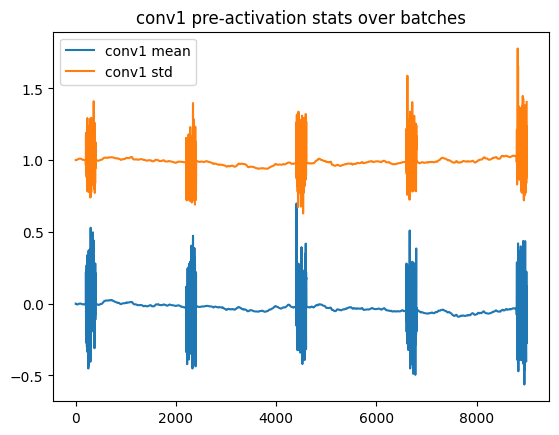

In [22]:
plot_layer_stats('conv1')

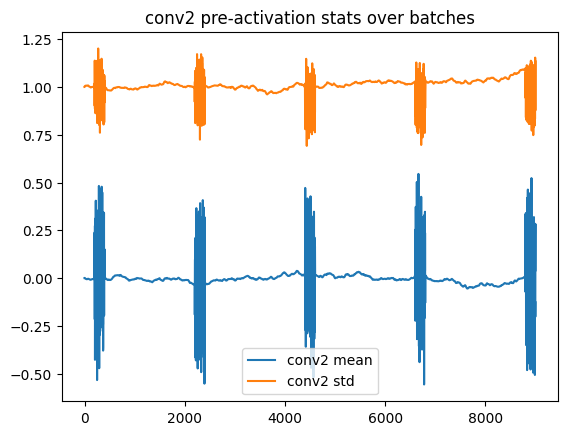

In [23]:
plot_layer_stats('conv2')

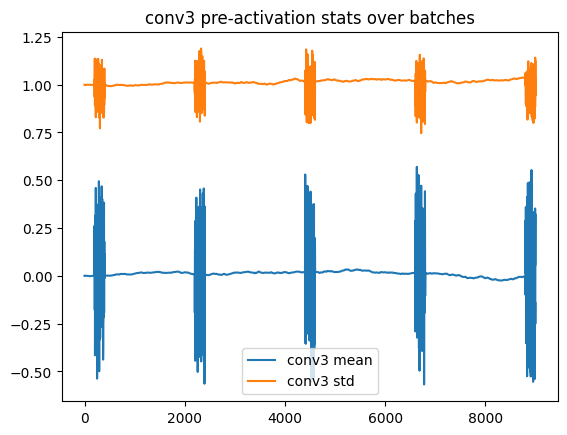

In [24]:
plot_layer_stats('conv3')

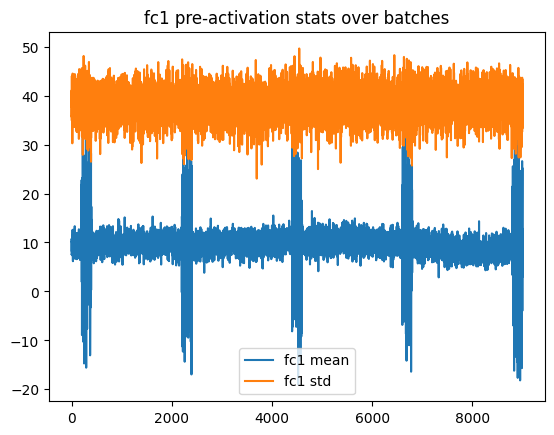

In [25]:
plot_layer_stats('fc1')

In [ ]:
# print pyro param store names and shapes
for name, param in pyro.get_param_store().items():
    print(f"{name:40s} → {param.shape} on {param.device}")

In [ ]:
plot_layer_stats('conv3')

In [ ]:
plot_layer_stats('fc1')

### Eurosat's Model

In [ ]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

class BayesianCNNSingleFC(PyroModule):
    def __init__(
        self,
        num_classes,
        device,
        activation='sigmoid',
        prior_dist='gaussian',
        mu=0,
        b=10.0,
        prior_params=None
    ):
        super().__init__()

        # Store device
        self.device = device

        # Activation setup: accept string or callable
        if isinstance(activation, str):
            act_map = {
                'relu': F.relu,
                'tanh': F.tanh,
                'wg': self.actWG,
                'rwg': self.actRWG,
                'sigmoid': F.sigmoid,
                'sinusoidal': torch.sin,
                'relu6': F.relu6,
                'leaky_relu': F.leaky_relu,
                'selu': F.selu,
            }
            try:
                self.activation_fn = act_map[activation]
            except KeyError:
                raise ValueError(f"Unsupported activation: {activation}")
        elif callable(activation):
            self.activation_fn = activation
        else:
            raise ValueError("activation must be a string or callable")

        # Prior distribution setup
        self.prior_dist = prior_dist
        # Set default prior parameters if not provided
        default_params = {'mu': 0.0, 'b': 10.0}
        params = default_params if prior_params is None else prior_params
        self.prior_mu = torch.tensor(params.get('mu', params['mu']), device=device)
        self.prior_b  = torch.tensor(params.get('b', params['b']), device=device)

        print(f"Using prior distribution: {self.prior_dist} with mu={self.prior_mu.item()} and b={self.prior_b.item()}")

        # Layer definitions with priors
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(self._make_prior([32, 3, 5, 5]))
        self.conv1.bias   = PyroSample(self._make_prior([32]))
        self.bn1 = nn.BatchNorm2d(32)  # Use nn.BatchNorm2d directly, no PyroModule needed

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(self._make_prior([64, 32, 5, 5]))
        self.conv2.bias   = PyroSample(self._make_prior([64]))
        self.bn2 =  nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap  = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = PyroModule[nn.Linear](64, num_classes)
        self.fc1.weight = PyroSample(self._make_prior([num_classes, 64]))
        self.fc1.bias   = PyroSample(self._make_prior([num_classes]))

    def actWG(self, x, alpha=1.0):
        # Weight-gradient activation
        return x * torch.exp(-alpha * x ** 2)
    
    def actRWG(self, x, alpha=1.0):
        wg = x * torch.exp(-alpha * x ** 2)
        # compare elementwise with zero
        return torch.max(torch.zeros_like(wg), wg)

    def _make_prior(self, shape):
        """
        Construct a prior distribution based on self.prior_dist and parameters.
        """
        if self.prior_dist == 'gaussian':
            base = dist.Normal(self.prior_mu, self.prior_b)
        elif self.prior_dist == 'laplace':
            base = dist.Laplace(self.prior_mu, self.prior_b)
        elif self.prior_dist == 'uniform':
            # uniform over [-b, b]
            base = dist.Uniform(-self.prior_b, self.prior_b)
        else:
            raise ValueError(f"Unsupported prior distribution: {self.prior_dist}")
        return base.expand(shape).to_event(len(shape))

    def forward(self, x, y=None):
        # x: [B, 3, 64, 64]
        #x = self.activation_fn(self.conv1(x).to(self.device))
        x = self.conv1(x).to(self.device)
        x = self.bn1(x)
        x = self.activation_fn(x)
        x = self.pool(x)
        #x = self.activation_fn(self.conv2(x))
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation_fn(x)
        x = self.pool(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        logits = self.fc1(x)

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

        return logits

In [ ]:
eurosat_mean = [0.344, 0.380, 0.408]
eurosat_std  = [0.190, 0.137, 0.115]

old_mean = [0.3444, 0.3803, 0.4078]
old_std = [0.0914, 0.0651, 0.0552]


def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=eurosat_mean, 
                             std=eurosat_std)
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=True)

    torch.manual_seed(42)

    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [ ]:
import torch
import pyro.poutine as poutine
from pyro.infer import Trace_ELBO

elbo = Trace_ELBO()


import torch
import pyro.poutine as poutine

def compute_kl_nll_full(model, guide, x, y):
    # 1) Trace the guide (latent-only)
    guide_trace = poutine.trace(guide).get_trace(x, y)
    # 2) Replay the model with those latent samples
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)
    ).get_trace(x, y)

    kl  = torch.tensor(0., device=x.device)
    nll = torch.tensor(0., device=x.device)

    def sum_lp(site):
        # Try built-in sums first
        if "log_prob_sum" in site:
            return site["log_prob_sum"]
        if "log_prob" in site:
            return site["log_prob"].sum()
        # Fallback to calling fn.log_prob
        lp = site["fn"].log_prob(site["value"])
        return lp.sum()

    # KL from all latent sites in the guide
    for name, site in guide_trace.nodes.items():
        if site["type"] != "sample" or site["is_observed"]:
            continue
        if name not in model_trace.nodes:
            continue
        q_lp = sum_lp(site)
        p_lp = sum_lp(model_trace.nodes[name])
        kl   = kl + (q_lp - p_lp)

    # NLL from the observed "obs" site in the model
    for name, site in model_trace.nodes.items():
        if site["type"] == "sample" and site["is_observed"]:
            # negative log-likelihood = -sum log p(y|x,w)
            nll = nll - sum_lp(site)

    return kl, nll


In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from tqdm import tqdm
import pandas as pd

In [ ]:
num_classes = 10

bayesian_model = BayesianCNNSingleFC(num_classes,
        device,
        activation='relu',
        prior_dist='gaussian',
        prior_params={'mu': 0.0, 'b': 2.0})

#act_name  = getattr(bayesian_model, 'activation', getattr(bayesian_model, 'activation', 'act'))
#prior_name = getattr(bayesian_model, 'prior_dist', 'prior')

#guide = AutoDiagonalNormal(bayesian_model)

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide.initialization import init_to_median
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

# 1) construct your guide so its locs start at p(w).mean=0
guide = AutoDiagonalNormal(
    bayesian_model,
    init_loc_fn=init_to_median(num_samples=1),   # all μ_q ← prior mean (0)
    init_scale=0.1               # set initial σ_q=0.1
)

optimizer = Adam({"lr": 1e-3,"weight_decay": 1e-4})  # Increased from 1e-4 to 1e-3, and added weight decay
svi = pyro.infer.SVI(model=bayesian_model,
                     guide=guide,
                     optim=optimizer,
                     #loss=pyro.infer.Trace_ELBO(num_particles=1,
                     #                           )) #TODO
                     loss=elbo)


In [ ]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)

In [ ]:
losses, accuracies, accuracy_epochs, weight_stats, bias_stats, best_model_path, best_guide_path, best_param_store_path, experiment_timestamp = train_svi_with_stats(
    bayesian_model,
    guide,
    svi,
    train_loader,
    device,
    num_epochs=10,
    save_epochs=None,
    save_dir='results_GP_eurosat_TEST')

In [ ]:
def plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats, act_name, prior_name, timestamp):
    """Plot training results with weight and bias statistics"""
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.grid(True)
    
    # Plot 2: Training Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(accuracy_epochs, accuracies, 'o-')
    plt.title('Training Accuracy (Every 10 Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    # Plot 3: Weight Statistics Boxplot
    plt.subplot(2, 2, 3)
    weight_data = []
    weight_labels = []
    
    for i, epoch in enumerate(weight_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = weight_stats['means'][i] + weight_stats['stds'][i]
        weight_data.append(epoch_data)
        weight_labels.append(f'Epoch {epoch}')
    
    if weight_data:
        bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)
        for patch in bp1['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.title('LOC Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('LOC Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Bias Statistics Boxplot
    plt.subplot(2, 2, 4)
    bias_data = []
    bias_labels = []
    
    for i, epoch in enumerate(bias_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = bias_stats['means'][i] + bias_stats['stds'][i]
        bias_data.append(epoch_data)
        bias_labels.append(f'Epoch {epoch}')
    
    if bias_data:
        bp2 = plt.boxplot(bias_data, tick_labels=bias_labels, patch_artist=True)
        for patch in bp2['boxes']:
            patch.set_facecolor('lightcoral')
    
    plt.title('SCALE Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('SCALE Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'results_GP_eurosat/bayesian_cnn_training_results_{act_name}_{prior_name}_{timestamp}.png')
    plt.show()

In [ ]:
act_name = bayesian_model.activation_fn.__name__ if hasattr(bayesian_model.activation_fn, '__name__') else str(bayesian_model.activation_fn)
prior_name = getattr(bayesian_model, 'prior_dist', 'prior')

In [ ]:
plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats, act_name, prior_name, experiment_timestamp)

In [ ]:
# clear the parameter store and reload the parameter store from the best result
pyro.clear_param_store()

bayesian_model.load_state_dict(torch.load(best_model_path))
guide.load_state_dict(torch.load(best_guide_path))
pyro.get_param_store().set_state(torch.load(best_param_store_path,weights_only=False))

In [ ]:
# print confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix


def predict_data(model, loader_of_interest, num_samples=10):
    model.eval()
    guide.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(loader_of_interest, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            logits_mc = torch.zeros(num_samples, images.size(0), model.fc1.out_features).to(device)

            for i in range(num_samples):
                guide_trace = pyro.poutine.trace(guide).get_trace(images)
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits = replayed_model(images)
                logits_mc[i] = logits

            avg_logits = logits_mc.mean(dim=0)
            predictions = torch.argmax(avg_logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

In [ ]:
all_labels, all_predictions = predict_data(bayesian_model, test_loader, num_samples=10)
cm = confusion_matrix(all_labels, all_predictions)
#print accuracy from confusion matrix
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy * 100:.6f}%")

In [ ]:
df = pd.DataFrame({'True Label': all_labels, 'Predicted Label': all_predictions})

In [ ]:
#save the prediction label and true label in a csv file

def save_predictions_to_csv(labels, predictions, filename='predictions.csv'):
    df = pd.DataFrame({'True Label': labels, 'Predicted Label': predictions})
    df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

In [ ]:
save_predictions_to_csv(all_labels, all_predictions, os.path.join('results_GP_eurosat', f'predictions_{act_name}_{prior_name}_{experiment_timestamp}_{accuracy * 100:.0f}.csv'))

In [ ]:
# print pyro param store values
for name, param in pyro.get_param_store().items():
    if 'loc' in name or 'scale' in name:
        print(f"{name}: {param.detach().cpu().numpy()}")